In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from xgboost import plot_importance
import pgeocode

/var/folders/bn/jml31c0j6j78dy8hy8nh2hwr0000gn/T/ipykernel_71065/1402485391.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Import data

In [2]:
train = pd.read_csv("training.csv")
len(train)

12906

Variables (likely to affect diagnosis) to transform:
- `patient_race`: encode to discrete values
- `payer_type`: encode
- `patient_state`: encode
- `patient_zip3`: encode
- `patient_gender`: encode
- `bmi`: standardize
- `breast_cancer_diagnosis_code`: encode
- `breast_cancer_diagnosis_code_desc`: potentially transform with NLP
- `metastatic_cancer_diagnosis_code`: encode
- `metastatic_first_novel_treatment`: encode
- `metastatic_first_novel_treatment_type`: encode (or potentially drop since there is only one value -- check if this is only populated when a `metastatic_first_novel_treatment` exists)
- `Region`: encode
- `Division`: encode (is this repeating info from zip code?)
- `population`: standardize (is this needed if density is given?)
- `density`: standardize
- `family_size`: standardize
- `income_household_median`: standardize
- `ozone`: standardize
- `PM25`: standardize
- `N02`: standardize



Consider:
- technique to determine which variables are/aren't strong predictors of diagnosis
- replace zip code with latitude and longitude so that they're easier to deal with - allows for predictions with new zipcodes (not possible through just encoding) and helpful for tree models

In [3]:
train_dummies = pd.get_dummies(train)

### Feature Selection

In [4]:
# split train into X and y
X_train = train_dummies[[col for col in train_dummies.columns if col != 'DiagPeriodL90D']]
X_train.drop(columns=['patient_id'], inplace=True)
y_train = train_dummies['DiagPeriodL90D']

/var/folders/bn/jml31c0j6j78dy8hy8nh2hwr0000gn/T/ipykernel_71065/912122293.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(columns=['patient_id'], inplace=True)


In [5]:
# fit XGB model
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

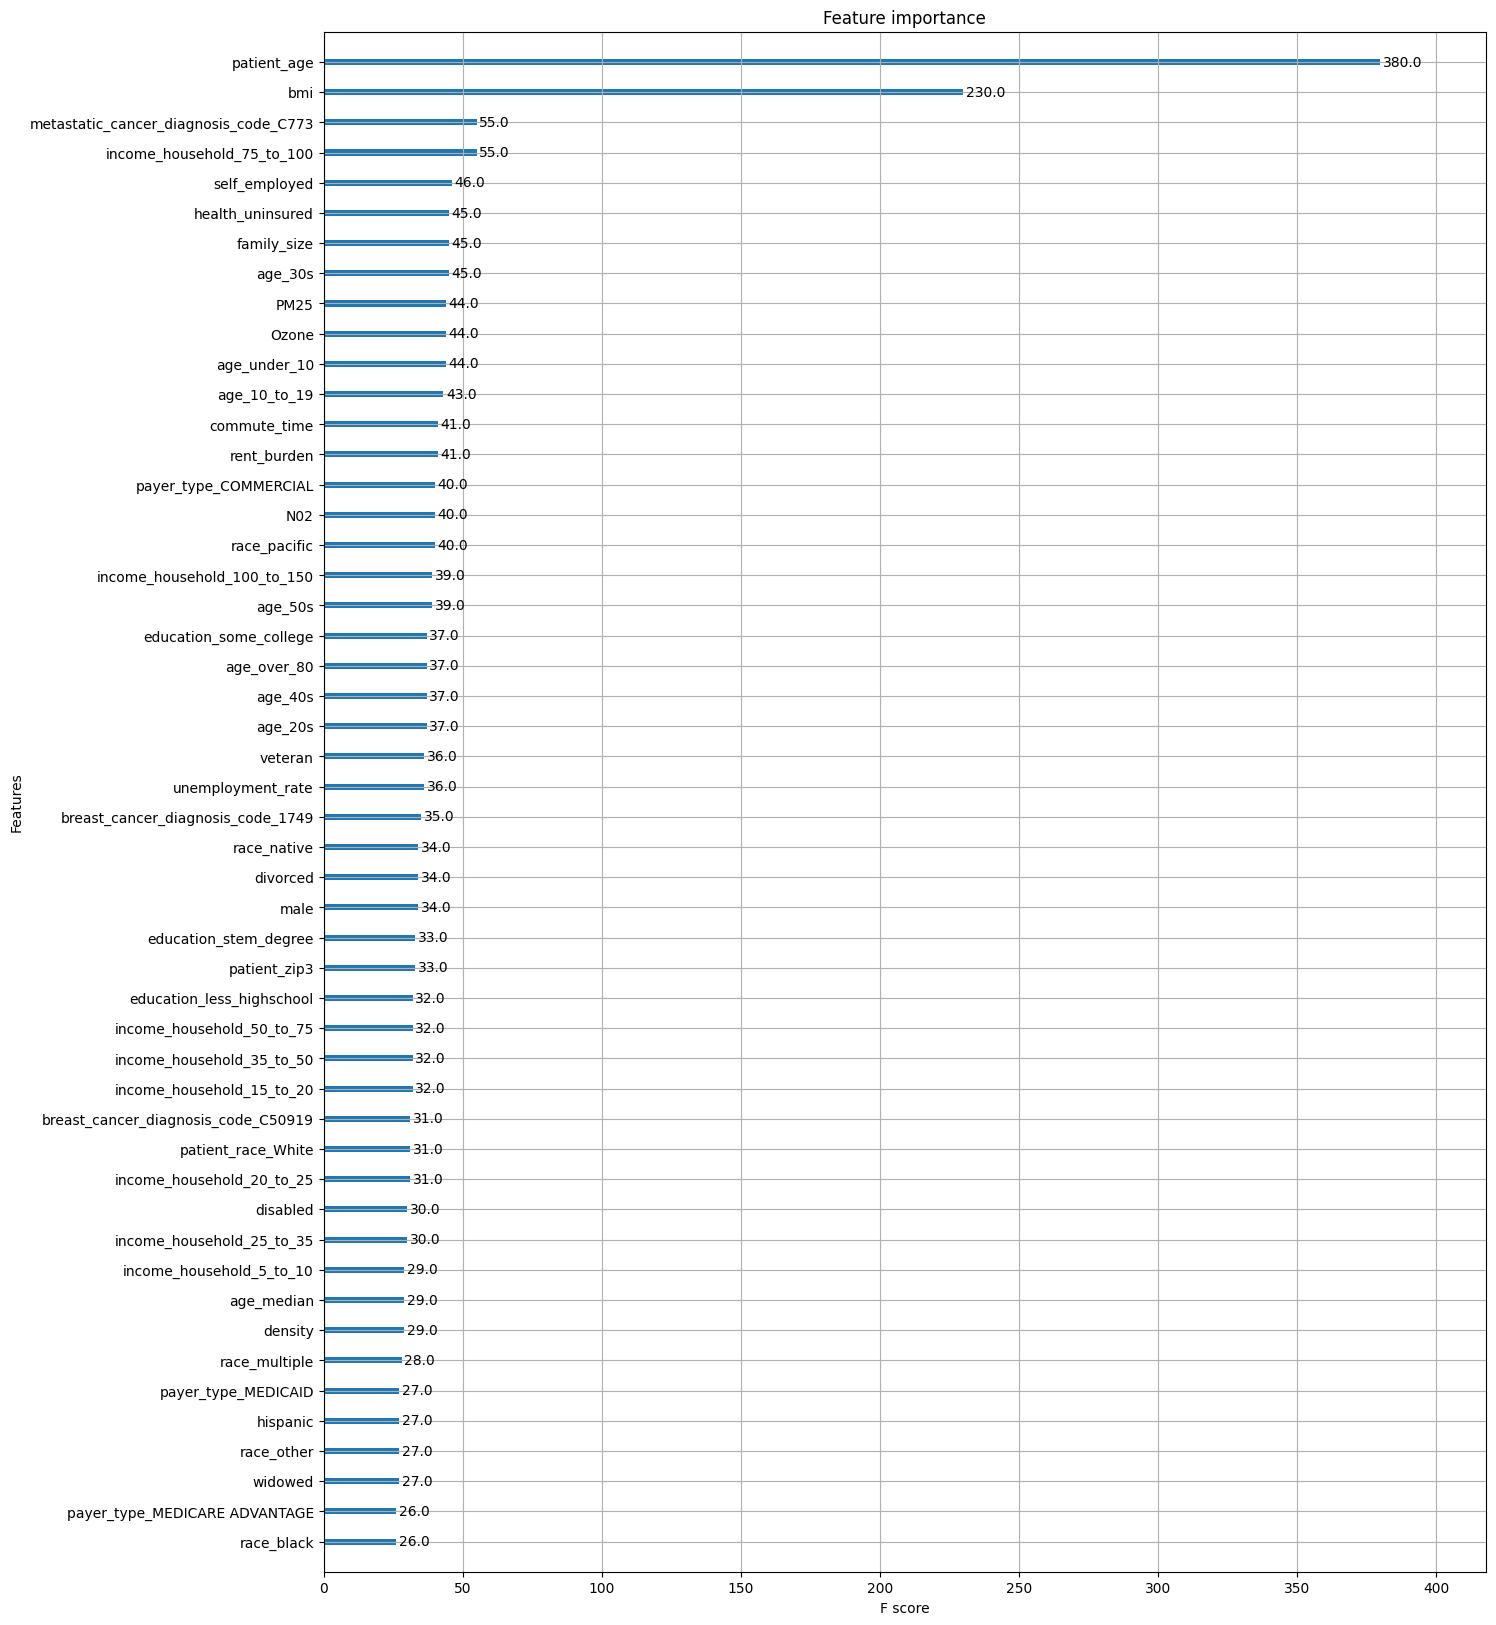

In [6]:
plt.rcParams["figure.figsize"] = (15,20)
plot_importance(model, max_num_features=50)

### EDA

In [7]:
train.describe()

,patient_id,patient_zip3,patient_age,bmi,population,density,age_median,age_under_10,age_10_to_19,age_20s,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
count,12906.000000,12906.000000,12906.000000,3941.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,...,12905.000000,12902.000000,12902.000000,12905.000000,12905.000000,12905.000000,12877.000000,12877.000000,12877.000000,12906.000000
mean,547381.196033,573.754300,59.183326,28.984539,20744.441237,1581.950419,40.502259,11.122784,12.945265,13.290376,...,13.335299,13.406950,4.474956,27.978387,8.575284,7.083376,39.822352,7.475221,16.098988,0.624516
std,260404.959974,275.447534,13.335216,5.696906,13886.903756,2966.305306,4.036963,1.512376,1.923974,3.354103,...,3.690949,5.222495,4.837085,5.083939,4.203482,3.109022,3.559492,1.516499,5.842501,0.484266
min,100063.000000,101.000000,18.000000,14.000000,635.545455,0.916667,20.600000,0.000000,6.314286,5.925000,...,4.600000,3.433333,0.000000,12.460784,2.440000,1.200000,30.939316,2.636008,2.760371,0.000000
25%,321517.000000,331.000000,50.000000,24.660000,9463.896552,171.857143,37.129825,10.160000,11.741176,11.013415,...,10.270492,9.663333,0.994444,24.933333,5.618750,4.929688,37.698880,6.651215,11.280694,0.000000
50%,543522.000000,554.000000,59.000000,28.190000,19154.190480,700.337500,40.639344,11.039216,12.923944,12.538095,...,12.884000,12.177778,2.747222,27.788235,7.465714,6.847059,39.108249,7.686577,15.589148,1.000000
75%,772671.750000,846.000000,67.000000,32.920000,30021.278690,1666.515385,42.934783,12.190000,14.019767,14.971053,...,15.555405,16.635556,5.976000,30.709375,10.617442,8.620000,41.136513,8.276922,20.801880,1.000000
max,999896.000000,999.000000,91.000000,85.000000,71374.131580,21172.000000,54.570000,17.675000,35.300000,62.100000,...,35.155556,38.347826,26.755000,48.020000,27.566102,25.200000,52.237210,11.169408,31.504775,1.000000


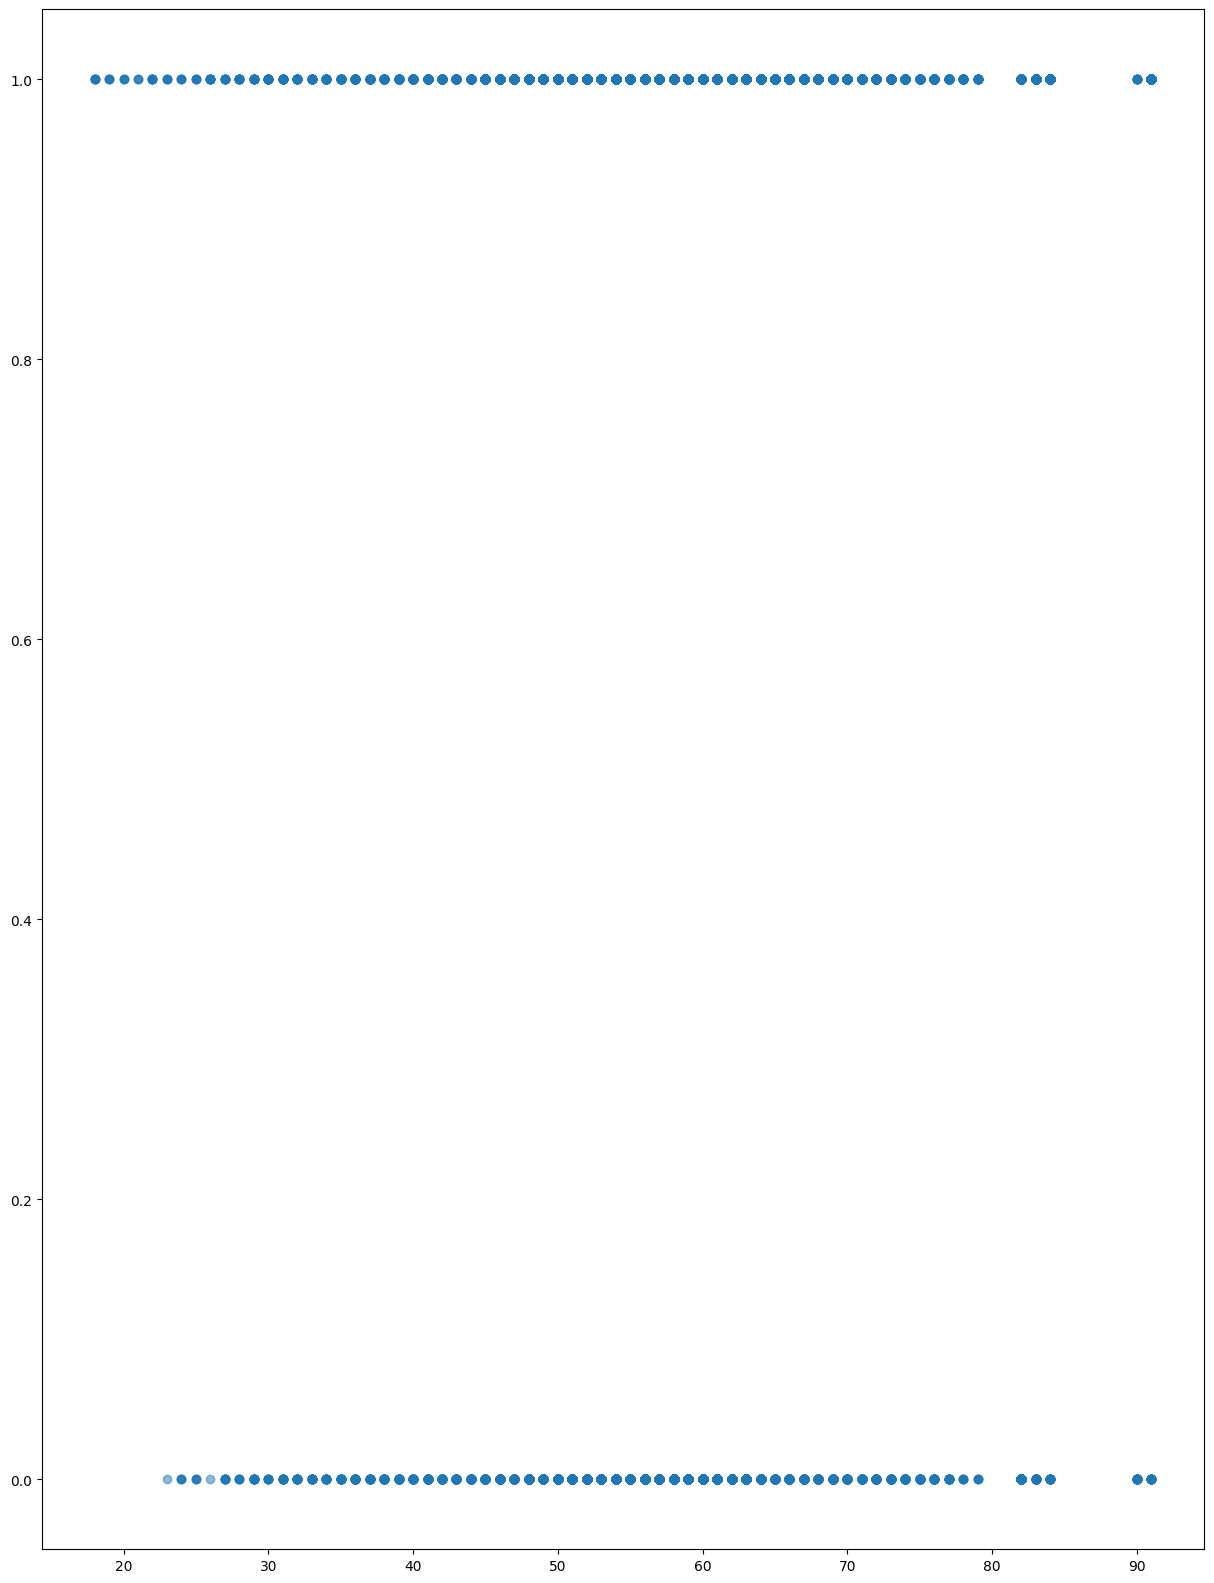

In [8]:
plt.scatter(train['patient_age'], train['DiagPeriodL90D'], alpha=0.5)

### Converting zip codes to latitude and longitude

In [9]:
train

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,...,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
1,349367,White,COMMERCIAL,CA,928,62,F,28.49,C50411,Malig neoplm of upper-outer quadrant of right ...,...,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
2,138632,White,COMMERCIAL,TX,760,43,F,38.09,C50112,Malignant neoplasm of central portion of left ...,...,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1
3,617843,White,COMMERCIAL,CA,926,45,F,NaN,C50212,Malig neoplasm of upper-inner quadrant of left...,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,0
4,817482,NaN,COMMERCIAL,ID,836,55,F,NaN,1749,"Malignant neoplasm of breast (female), unspeci...",...,15.276000,11.224000,1.946000,26.170213,12.088000,13.106000,41.356058,4.110749,11.722197,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12901,674178,White,NaN,OH,436,50,F,32.11,C50411,Malig neoplm of upper-outer quadrant of right ...,...,17.400000,23.600000,0.864706,19.841176,6.300000,6.247059,38.753055,8.068682,21.140731,1
12902,452909,NaN,COMMERCIAL,CA,945,50,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,...,11.243210,7.837037,5.411250,34.700000,3.845679,5.671605,36.469947,6.265266,10.728732,1
12903,357486,NaN,COMMERCIAL,CA,926,61,F,29.24,C50912,Malignant neoplasm of unspecified site of left...,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,1
12904,935417,NaN,NaN,NY,112,37,F,31.00,1749,"Malignant neoplasm of breast (female), unspeci...",...,10.194737,18.642105,14.173684,42.502632,6.392105,1.755263,37.722740,7.879795,27.496367,0


In [10]:
# use this object to query lat and long based on zip code
nomi = pgeocode.Nominatim('us')

In [11]:
# first, map the patient_state and patient_zip3 to the full 5-digit zip code
# we will use this dataset from https://data.opendatasoft.com/explore/dataset/georef-united-states-of-america-zc-point%40public/table/?flg=en-us
# which has full zip code and state
zip_state = pd.read_csv('uszips.csv', sep=';')
# drop the columns we don't need
zip_state = zip_state[['Zip Code', 'Official USPS State Code']]
zip_state = zip_state.rename(columns={'Zip Code': 'zipcode', 'Official USPS State Code': 'state'})
zip_state

,zipcode,state
0,90005,CA
1,90006,CA
2,90008,CA
3,90040,CA
4,90045,CA
...,...,...
33116,99589,AK
33117,99606,AK
33118,99626,AK
33119,99637,AK


In [12]:
#add zip3 to zip_state
# convert the zip to a string and pad the front with 0s
zip_state['zipcode'] = zip_state['zipcode'].astype(str).str.zfill(5)
# take the last 3 digits
zip_state['zip3'] = zip_state['zipcode'].str[-3:]
print(sum(zip_state['zip3'].isna()))
print(sum(zip_state['state'].isna()))
print(sum(zip_state['zipcode'].isna()))
zip_state

0
0
0


,zipcode,state,zip3
0,90005,CA,005
1,90006,CA,006
2,90008,CA,008
3,90040,CA,040
4,90045,CA,045
...,...,...,...
33116,99589,AK,589
33117,99606,AK,606
33118,99626,AK,626
33119,99637,AK,637


In [13]:
# convert the zip3 in train dataset to str
train['patient_zip3'] = train['patient_zip3'].astype(str)

In [14]:
print(sum(train["patient_state"].isnull()))
print(sum(train["patient_zip3"].isnull()))
print(sum(zip_state["state"].isnull()))
print(sum(zip_state["zip3"].isnull()))

51
0
0
0


In [15]:
# investigating missing zip codes 
print(list(set(train.patient_zip3) - set(zip_state.zip3)))
print(list(set(zip_state.zip3) - set(train.patient_zip3))) #expected that not all existing zips will be on patient list

['500', '300', '600', '200', '900', '800', '400', '700']
['667', '569', '588', '538', '268', '024', '032', '690', '266', '369', '039', '643', '845', '052', '682', '028', '824', '428', '068', '086', '097', '078', '645', '040', '083', '699', '364', '529', '854', '898', '035', '683', '066', '017', '867', '006', '887', '966', '715', '892', '595', '269', '218', '038', '094', '013', '355', '219', '092', '073', '964', '771', '051', '884', '102', '865', '942', '258', '818', '088', '518', '077', '055', '091', '676', '085', '753', '861', '007', '586', '058', '848', '459', '099', '012', '533', '093', '817', '885', '018', '697', '584', '027', '513', '674', '889', '823', '167', '353', '250', '044', '869', '644', '896', '203', '572', '876', '003', '004', '642', '362', '677', '079', '583', '399', '192', '025', '050', '663', '632', '036', '909', '673', '026', '717', '019', '692', '014', '063', '081', '843', '082', '822', '042', '061', '821', '580', '030', '521', '962', '205', '057', '048', '033', '084

In [16]:
zip_state.loc[zip_state['zip3'] == "200"]

,zipcode,state,zip3


In [17]:
train.loc[train['patient_zip3'] == "200"].head()

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
236,225060,Black,MEDICAID,DC,200,60,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,...,9.4,19.016667,3.195455,26.684615,2.876923,3.507692,39.565648,7.716444,16.86895,1
804,260160,Black,NaN,DC,200,58,F,NaN,C50511,Malig neoplm of lower-outer quadrant of right ...,...,9.4,19.016667,3.195455,26.684615,2.876923,3.507692,39.565648,7.716444,16.86895,0
1149,793522,NaN,COMMERCIAL,DC,200,29,F,20.23,C50212,Malig neoplasm of upper-inner quadrant of left...,...,9.4,19.016667,3.195455,26.684615,2.876923,3.507692,39.565648,7.716444,16.86895,1
1332,336412,Hispanic,MEDICAID,DC,200,53,F,NaN,C50512,Malig neoplasm of lower-outer quadrant of left...,...,9.4,19.016667,3.195455,26.684615,2.876923,3.507692,39.565648,7.716444,16.86895,1
1694,817742,Black,MEDICAID,DC,200,52,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,...,9.4,19.016667,3.195455,26.684615,2.876923,3.507692,39.565648,7.716444,16.86895,0


In [18]:
pd.set_option('display.max_columns', None)
zip_state.loc[zip_state['state'] == "DC"]

,zipcode,state,zip3
310,20009,DC,009
314,20245,DC,245
315,20553,DC,553
2225,20373,DC,373
2226,20535,DC,535
3065,20019,DC,019
3068,20230,DC,230
4303,20012,DC,012
4304,20036,DC,036
4308,20565,DC,565


In [19]:
# add missing zip3 / state to zip_state (just picked the first one from the train dataset with matching state)
data = [
    ['20009', 'DC', "200"],
    ['30075', 'GA', "300"],
    ['40014', 'KY', "400"],
    ['50051', 'IA', "500"],
    ['60015', 'IL', "600"],
    ['70339', 'LA', "700"],
    ['80117', 'CO', "800"],
    ['90005', 'CA', "900"]
]

In [20]:
missing_zip3s = pd.DataFrame(data, columns=['zipcode', 'state', 'zip3'])
missing_zip3s

,zipcode,state,zip3
0,20009,DC,200
1,30075,GA,300
2,40014,KY,400
3,50051,IA,500
4,60015,IL,600
5,70339,LA,700
6,80117,CO,800
7,90005,CA,900


In [21]:
zip_state = pd.concat([zip_state, missing_zip3s], ignore_index=True)

In [22]:
# old length = 33121
print(len(zip_state))
print(zip_state.loc[zip_state['zip3'] == "200"]) # new record found! 
print(list(set(train.patient_zip3) - set(zip_state.zip3)))

33129
      zipcode state zip3
33121   20009    DC  200
[]


In [23]:
print(sum(train["patient_state"].isnull()))
print(sum(train["patient_zip3"].isnull()))
print(sum(zip_state["state"].isnull()))
print(sum(zip_state["zip3"].isnull()))

51
0
0
0


In [24]:
# convert the zip3 in train dataset to str
train['patient_zip3'] = train['patient_zip3'].astype(str)

In [25]:
# merge our training dataset with zip_state to map the full 5-digit zip to each entry
train_merged = pd.merge(train, zip_state, left_on=['patient_zip3'], right_on = ['zip3'], how='left')
print(sum(train_merged["patient_state"].isnull()))
print(sum(train_merged["patient_zip3"].isnull()))
print(sum(train_merged["state"].isnull()))
print(sum(train_merged["zip3"].isnull()))
train_merged

1740
0
0
0


,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,Region,Division,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D,zipcode,state,zip3
0,475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,NaN,NaN,West,Pacific,31437.75000,1189.562500,30.642857,16.014286,15.542857,17.614286,14.014286,11.614286,11.557143,7.571429,4.000000,2.100000,49.857143,50.142857,36.571429,11.885714,47.114286,4.442857,3.928571,52.228571,52996.28571,3.142857,4.000000,6.157143,5.142857,6.271429,10.142857,13.300000,20.000000,12.742857,11.571429,7.528571,19.100000,24563.57143,44.585714,8674.50000,264634.2857,1165.000000,37.442857,33.257143,29.20000,25.914286,8.357143,3.257143,11.614286,39.557143,61.528571,8.471429,13.428571,0.000000,44.100000,13.1,5.10000,1.485714,0.342857,27.114286,8.757143,66.685714,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1,47924,IN,924
1,475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,NaN,NaN,West,Pacific,31437.75000,1189.562500,30.642857,16.014286,15.542857,17.614286,14.014286,11.614286,11.557143,7.571429,4.000000,2.100000,49.857143,50.142857,36.571429,11.885714,47.114286,4.442857,3.928571,52.228571,52996.28571,3.142857,4.000000,6.157143,5.142857,6.271429,10.142857,13.300000,20.000000,12.742857,11.571429,7.528571,19.100000,24563.57143,44.585714,8674.50000,264634.2857,1165.000000,37.442857,33.257143,29.20000,25.914286,8.357143,3.257143,11.614286,39.557143,61.528571,8.471429,13.428571,0.000000,44.100000,13.1,5.10000,1.485714,0.342857,27.114286,8.757143,66.685714,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1,53924,WI,924
2,475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,NaN,NaN,West,Pacific,31437.75000,1189.562500,30.642857,16.014286,15.542857,17.614286,14.014286,11.614286,11.557143,7.571429,4.000000,2.100000,49.857143,50.142857,36.571429,11.885714,47.114286,4.442857,3.928571,52.228571,52996.28571,3.142857,4.000000,6.157143,5.142857,6.271429,10.142857,13.300000,20.000000,12.742857,11.571429,7.528571,19.100000,24563.57143,44.585714,8674.50000,264634.2857,1165.000000,37.442857,33.257143,29.20000,25.914286,8.357143,3.257143,11.614286,39.557143,61.528571,8.471429,13.428571,0.000000,44.100000,13.1,5.10000,1.485714,0.342857,27.114286,8.757143,66.685714,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1,85924,AZ,924
3,475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,NaN,NaN,West,Pacific,31437.75000,1189.562500,30.642857,16.014286,15.542857,17.614286,14.014286,11.614286,11.557143,7.571429,4.000000,2.100000,49.857143,50.142857,36.571429,11.885714,47.11428

In [26]:
# # merge our training dataset with zip_state to map the full 5-digit zip to each entry
# train_merged = pd.merge(train, zip_state, left_on=['patient_state', 'patient_zip3'],
#                  right_on = ['state', 'zip3'], how='left')

In [27]:
# drop the duplicate columns
# we were dropping the new columns from zip_state (state and zip3) but keeping train.patient_zip3 and train.patient_state. 
# this means that we were keeping the column with null states, instead of keeping the new, fully populated state column from zip_state. 
train_merged.drop(columns=['patient_zip3', 'patient_state'], inplace=True)
train_merged

,patient_id,patient_race,payer_type,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,Region,Division,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D,zipcode,state,zip3
0,475714,NaN,MEDICAID,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,NaN,NaN,West,Pacific,31437.75000,1189.562500,30.642857,16.014286,15.542857,17.614286,14.014286,11.614286,11.557143,7.571429,4.000000,2.100000,49.857143,50.142857,36.571429,11.885714,47.114286,4.442857,3.928571,52.228571,52996.28571,3.142857,4.000000,6.157143,5.142857,6.271429,10.142857,13.300000,20.000000,12.742857,11.571429,7.528571,19.100000,24563.57143,44.585714,8674.50000,264634.2857,1165.000000,37.442857,33.257143,29.20000,25.914286,8.357143,3.257143,11.614286,39.557143,61.528571,8.471429,13.428571,0.000000,44.100000,13.1,5.10000,1.485714,0.342857,27.114286,8.757143,66.685714,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1,47924,IN,924
1,475714,NaN,MEDICAID,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,NaN,NaN,West,Pacific,31437.75000,1189.562500,30.642857,16.014286,15.542857,17.614286,14.014286,11.614286,11.557143,7.571429,4.000000,2.100000,49.857143,50.142857,36.571429,11.885714,47.114286,4.442857,3.928571,52.228571,52996.28571,3.142857,4.000000,6.157143,5.142857,6.271429,10.142857,13.300000,20.000000,12.742857,11.571429,7.528571,19.100000,24563.57143,44.585714,8674.50000,264634.2857,1165.000000,37.442857,33.257143,29.20000,25.914286,8.357143,3.257143,11.614286,39.557143,61.528571,8.471429,13.428571,0.000000,44.100000,13.1,5.10000,1.485714,0.342857,27.114286,8.757143,66.685714,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1,53924,WI,924
2,475714,NaN,MEDICAID,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,NaN,NaN,West,Pacific,31437.75000,1189.562500,30.642857,16.014286,15.542857,17.614286,14.014286,11.614286,11.557143,7.571429,4.000000,2.100000,49.857143,50.142857,36.571429,11.885714,47.114286,4.442857,3.928571,52.228571,52996.28571,3.142857,4.000000,6.157143,5.142857,6.271429,10.142857,13.300000,20.000000,12.742857,11.571429,7.528571,19.100000,24563.57143,44.585714,8674.50000,264634.2857,1165.000000,37.442857,33.257143,29.20000,25.914286,8.357143,3.257143,11.614286,39.557143,61.528571,8.471429,13.428571,0.000000,44.100000,13.1,5.10000,1.485714,0.342857,27.114286,8.757143,66.685714,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1,85924,AZ,924
3,475714,NaN,MEDICAID,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,NaN,NaN,West,Pacific,31437.75000,1189.562500,30.642857,16.014286,15.542857,17.614286,14.014286,11.614286,11.557143,7.571429,4.000000,2.100000,49.857143,50.142857,36.571429,11.885714,47.114286,4.442857,3.928571,52.228571,52996.28571,3.142857,4.00

In [28]:
len(train_merged)

421035

In [29]:
# for some State and zip3 combos, there are multiple zip codes associated, leading to duplicate patient_id rows.
# it is impossible to tell which zip code is correct because we don't have that granularity of detail, so just keep the 1st record
train_merged = train_merged.drop_duplicates(subset='patient_id', keep='first')


In [30]:
print(sum(train_merged["state"].isnull()))
print(sum(train_merged["zip3"].isnull()))

0
0


In [31]:
len(train_merged)

12906

In [ ]:
# get the lat and long for each zipcode in a df from pgeocode by giving it a list of all unique zips in the dataset
# and keep only the lat, long, zipcode cols
latlong_df = nomi.query_postal_code(train_merged['zipcode'].unique())[['postal_code', 'latitude', 'longitude']]
latlong_df['postal_code'] = latlong_df['postal_code'].astype(str)
latlong_df

In [33]:
# merge the lat long data with the rest of the data
train_latlong = pd.merge(train_merged, latlong_df, left_on='zipcode', right_on='postal_code', how='left').drop(columns=['postal_code'])

In [36]:
# # I dropped old columns instead of new. This is code to rename new cols to be same as old so that jasmine doesn't have to redo any code.
# train_latlong.rename(columns={"state": "patient_state", "zip3": "patient_zip3"})
# train_latlong.columns

Index(['patient_id', 'patient_race', 'payer_type', 'patient_age',
       'patient_gender', 'bmi', 'breast_cancer_diagnosis_code',
       'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code',
       'metastatic_first_novel_treatment',
       'metastatic_first_novel_treatment_type', 'Region', 'Division',
       'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19',
       'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s',
       'age_over_80', 'male', 'female', 'married', 'divorced', 'never_married',
       'widowed', 'family_size', 'family_dual_income',
       'income_household_median', 'income_household_under_5',
       'income_household_5_to_10', 'income_household_10_to_15',
       'income_household_15_to_20', 'income_household_20_to_25',
       'income_household_25_to_35', 'income_household_35_to_50',
       'income_household_50_to_75', 'income_household_75_to_100',
       'income_household_100_to_150', 'income_household_150_over',
       

In [35]:
train_latlong.to_csv('train_latlong.csv', index=False)